<a href="https://colab.research.google.com/github/Quinta10/Malaria-cell-classification/blob/main/Malaria_cells_Keras_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<b>Milestone 2

###<b> Mounting the Drive

In [ ]:
# Mounting the drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###<b>Loading libraries</b>

In [ ]:
# Importing libraries required to load the data
import zipfile

import os

from PIL import Image

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf

import keras

from tensorflow.keras import optimizers

from tensorflow.keras.utils import to_categorical # To perform one-hot encoding

from tensorflow.keras.layers import BatchNormalization, LeakyReLU,MaxPooling2D, ELU

from tensorflow.keras.optimizers import Adam

# To ignore warnings
import warnings

warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)

pd.set_option("display.max_rows", 200)

### <b>Let us load the data</b>

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [ ]:
# Storing the path of the data file from the Google drive
""" I have commented out this cell, because 
when I run the notebook again and again i don't want the unzip to take time again"""

path = '/content/drive/MyDrive/Capstone/cell_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:

    zip_ref.extractall(path='/content/drive/MyDrive/Capstone/')

The files have been extracted to the local session of Google Colab. The extracted folder would have the following structure:

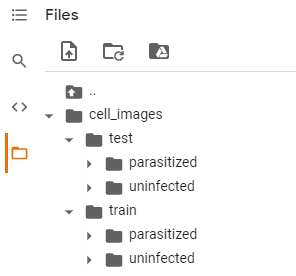

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [ ]:
# Storing the path of the extracted "train" folder 
train_dir = '/content/drive/MyDrive/Capstone/cell_images/train'

# Size of image so that each image has the same size
SIZE = 64

# Empty list to store the training images after they are converted to NumPy arrays
train_images = []

# Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [ ]:
# We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
from tqdm.autonotebook import tqdm

for folder_name in ['/parasitized/', '/uninfected/']:
    
    # Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
    
        try:
    
            # Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))

            # Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':
                
                train_labels.append(1)
            
            else:
            
                train_labels.append(0)
        
        except Exception:
        
            pass       

# Converting lists to arrays
train_images = np.array(train_images)

train_labels = np.array(train_labels)

In [ ]:
print(train_labels[10])

1


In [ ]:
# Storing the path of the extracted "test" folder 
test_dir = '/content/drive/MyDrive/Capstone/cell_images/test'

# Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

# Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

# Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [ ]:
# We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    # Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
     
        try:
            # Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))
            
            # Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':
                
                test_labels.append(1)
            
            else:
            
                test_labels.append(0)
        
        except Exception:
        
            pass       

# Converting lists to arrays
test_images = np.array(test_images)

test_labels = np.array(test_labels)

###<b>Normalize the images

In [ ]:
# Try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images = (train_images/255).astype('float32')

test_images = (test_images/255).astype('float32')

As we have done our preprocessing required and performed some EDA to gain some insights in our Milestone-1 so now we will try to build our model and try evaluating its performance.

###<B>One Hot Encoding on the train and test labels

In [ ]:
# Encoding Train Labels
train_labels = to_categorical(train_labels, 2)

# Similarly let us try to encode test labels
test_labels = to_categorical(test_labels, 2)

In [ ]:
print(train_labels[10])

[0. 1.]


### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [ ]:
# Clearing backend
from tensorflow.keras import backend

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout  

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from random import shuffle

backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

###<b> Building the model

In [ ]:
# Creating sequential model
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation = "relu"))

model.add(Dropout(0.4))

model.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

###<b> Compiling the model

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> Using Callbacks 

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and train our Model

In [ ]:
# Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history = model.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 13s 7ms/step - loss: 0.4204 - accuracy: 0.7970 - val_loss: 0.2018 - val_accuracy: 0.9171
Epoch 2/20
624/624 [==============================] - 4s 7ms/step - loss: 0.1192 - accuracy: 0.9571 - val_loss: 0.1591 - val_accuracy: 0.9655
Epoch 3/20
624/624 [==============================] - 4s 7ms/step - loss: 0.0950 - accuracy: 0.9698 - val_loss: 0.1005 - val_accuracy: 0.9822
Epoch 4/20
624/624 [==============================] - 4s 7ms/step - loss: 0.0781 - accuracy: 0.9743 - val_loss: 0.0762 - val_accuracy: 0.9850
Epoch 5/20
624/624 [==============================] - 4s 7ms/step - loss: 0.0716 - accuracy: 0.9768 - val_loss: 0.1401 - val_accuracy: 0.9712
Epoch 6/20
624/624 [==============================] - 5s 8ms/step - loss: 0.0667 - accuracy: 0.9779 - val_loss: 0.1188 - val_accuracy: 0.9734


###<b> Evaluating the model on test data

In [ ]:
accuracy = model.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 1s 7ms/step - loss: 0.1092 - accuracy: 0.9688

 Test_Accuracy:- 0.9688461422920227


<b> Plotting the confusion matrix

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1300
           1       0.97      0.97      0.97      1300

    accuracy                           0.97      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.97      0.97      0.97      2600



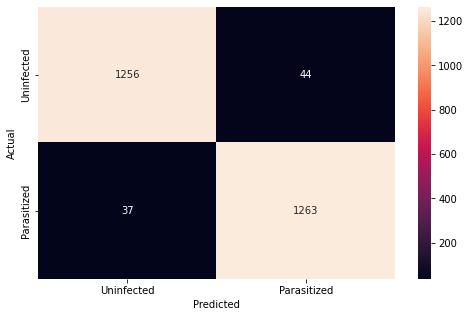

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

<b>Plotting the train and validation curves

In [ ]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

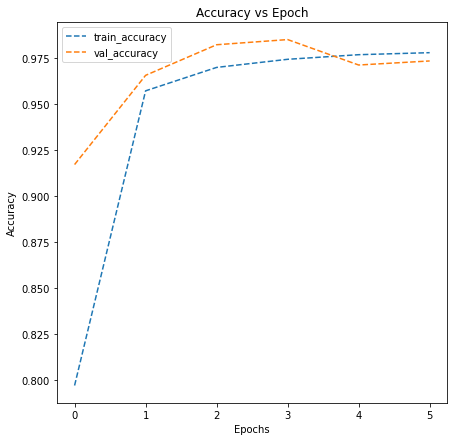

In [ ]:
plot_accuracy(history)



* Here we can clearly observe that the training and valiation accuracy are increasing 
* And we can also notice that validation accuracy is slightly higher than the train accuracy

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [ ]:
backend.clear_session() # Clearing the backend for new model

###<b> Building the Model

In [ ]:
# Creating sequential model1
model1 = Sequential()

model1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "leaky_relu", input_shape = (64, 64, 3)))

model1.add(MaxPooling2D(pool_size = 2))

model1.add(Dropout(0.2))

model1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "leaky_relu"))

model1.add(MaxPooling2D(pool_size = 2))

model1.add(Dropout(0.2))

model1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "leaky_relu"))

model1.add(MaxPooling2D(pool_size = 2))

model1.add(Dropout(0.2))

# new layers (we add it before Dense, because Dense layer has a side effect of
#     exponentially increasing the number of features)

#------------------ additional layer 1--------
model1.add(Conv2D(32, (3, 3),  padding = "same"))

model1.add(LeakyReLU(0.1))

model1.add(MaxPooling2D (pool_size = (2)))

#------------------ additional layer 2--------
model1.add(Conv2D(filters = 16, kernel_size = 2, padding = "same", activation = "leaky_relu"))

model1.add(MaxPooling2D(pool_size = 2))

model1.add(Dropout(0.2))
#---------------------------------------------

model1.add(Flatten())

model1.add(Dense(512, activation = "leaky_relu"))

model1.add(Dropout(0.4))

model1.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

###<b> Compiling the model

In [ ]:
model1.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

<b> Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
history1 = model1.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks,  validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 6s 9ms/step - loss: 0.3104 - accuracy: 0.8450 - val_loss: 0.1522 - val_accuracy: 0.9581
Epoch 2/20
624/624 [==============================] - 5s 8ms/step - loss: 0.0818 - accuracy: 0.9729 - val_loss: 0.1521 - val_accuracy: 0.9679
Epoch 3/20
624/624 [==============================] - 5s 7ms/step - loss: 0.0735 - accuracy: 0.9756 - val_loss: 0.1321 - val_accuracy: 0.9637
Epoch 4/20
624/624 [==============================] - 5s 8ms/step - loss: 0.0712 - accuracy: 0.9783 - val_loss: 0.1037 - val_accuracy: 0.9752
Epoch 5/20
624/624 [==============================] - 4s 7ms/step - loss: 0.0686 - accuracy: 0.9783 - val_loss: 0.0957 - val_accuracy: 0.9726
Epoch 6/20
624/624 [==============================] - 5s 8ms/step - loss: 0.0642 - accuracy: 0.9796 - val_loss: 0.1292 - val_accuracy: 0.9639
Epoch 7/20
624/624 [==============================] - 5s 8ms/step - loss: 0.0624 - accuracy: 0.9797 - val_loss: 0.1321 - val_accuracy: 0.9669


###<b> Evaluating the model

In [ ]:
accuracy1 = model1.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy1[1])

82/82 [==============================] - 1s 4ms/step - loss: 0.0883 - accuracy: 0.9788

 Test_Accuracy:- 0.9788461327552795


<b> Plotting the confusion matrix

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1300
           1       0.97      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



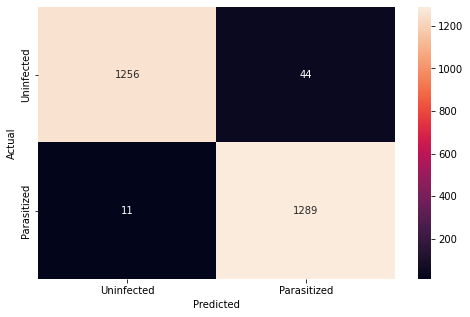

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model1.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

<b> Plotting the train and the validation curves

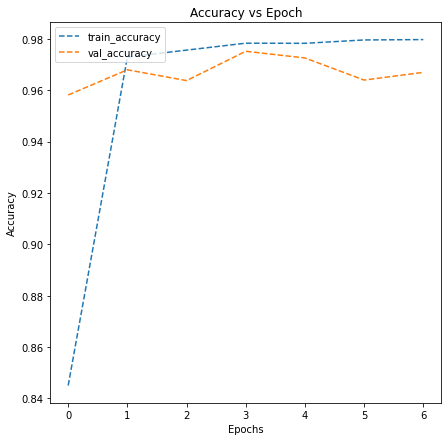

In [ ]:
plot_accuracy(history1)

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [ ]:
backend.clear_session() # Clearing the backend for new model

###<b> Building the Model

In [ ]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), padding = "same", activation = "leaky_relu", input_shape = (64, 64, 3)))

model2.add(MaxPooling2D(pool_size = 2))

model2.add(Dropout(0.2))

model2.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "leaky_relu"))

model2.add(MaxPooling2D(pool_size = 2))

#-----------BatchNormalization
model2.add(BatchNormalization())

model2.add(Dropout(0.2))

model2.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "leaky_relu"))

model2.add(MaxPooling2D(pool_size = 2))

model2.add(Dropout(0.2))

# new layers (we add it before Dense, because Dense layer has a side effect of
#     exponentially increasing the number of features)

#------------------ additional layer 1--------
model2.add(Conv2D(32, (3, 3),  padding = "same"))

model2.add(LeakyReLU(0.1))

model2.add(MaxPooling2D (pool_size = (2)))

#---------------BatchNormalization
model2.add(BatchNormalization())


#------------------ additional layer 2--------
model2.add(Conv2D(filters = 16, kernel_size = 2, padding = "same", activation = "leaky_relu"))

model2.add(MaxPooling2D(pool_size = 2))

model2.add(Dropout(0.2))
#---------------------------------------------

model2.add(Flatten())

model2.add(Dense(512, activation = "leaky_relu"))

model2.add(Dropout(0.4))

model2.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       1

###<b>Compiling the model

In [ ]:
adam = optimizers.Adam(learning_rate = 0.0001)

model2.compile(loss = "binary_crossentropy", optimizer = adam, metrics = ['accuracy'])

<b> Using callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and train the model

In [ ]:
history2 = model2.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 7s 10ms/step - loss: 0.6390 - accuracy: 0.6396 - val_loss: 1.2554 - val_accuracy: 0.0000e+00
Epoch 2/20
624/624 [==============================] - 5s 8ms/step - loss: 0.5709 - accuracy: 0.7002 - val_loss: 0.3463 - val_accuracy: 0.9603
Epoch 3/20
624/624 [==============================] - 5s 8ms/step - loss: 0.3063 - accuracy: 0.8827 - val_loss: 0.0508 - val_accuracy: 0.9984
Epoch 4/20
624/624 [==============================] - 5s 8ms/step - loss: 0.1496 - accuracy: 0.9475 - val_loss: 0.0365 - val_accuracy: 0.9962
Epoch 5/20
624/624 [==============================] - 5s 8ms/step - loss: 0.1171 - accuracy: 0.9603 - val_loss: 0.0482 - val_accuracy: 0.9938
Epoch 6/20
624/624 [==============================] - 5s 7ms/step - loss: 0.1045 - accuracy: 0.9641 - val_loss: 0.0634 - val_accuracy: 0.9894


<b>Plotting the train and validation accuracy

###<b>Evaluating the model

In [ ]:
# Evaluate the model to calculate the accuracy

accuracy2 = model2.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy2[1])

82/82 [==============================] - 1s 5ms/step - loss: 0.1222 - accuracy: 0.9488

 Test_Accuracy:- 0.948846161365509


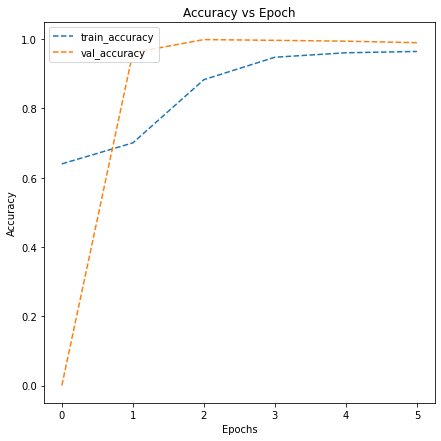

In [ ]:
# Plotting the accuracies
plot_accuracy(history2)

####<b>Observations and insights: 
## we experimented with the base model:
- *For Model1.* We added extra layers, which increased the 
It is expected that extra layer will extract more features from training images and provide higher accuracy on predicatons. However, extra layers come at the expense of computational resource. 

- *For Model2.* we added batch normalization.

It is expected that BatchNormalization imporives the data homegenuity between the layers and consequently allows a use of a higher learning rates, and makes dropout less necessary.  

In the models in keras that I have looked at: vgg16, ResNet50, ResNet50v2, etc BatchNormalization follow a pooling layer in a block.

*Important Note:* it is reported that the Batch Size is a fine tuning and important parameter that can change a lot.  

<b> Generate the classification report and confusion matrix 

82/82 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1300
           1       0.99      0.91      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



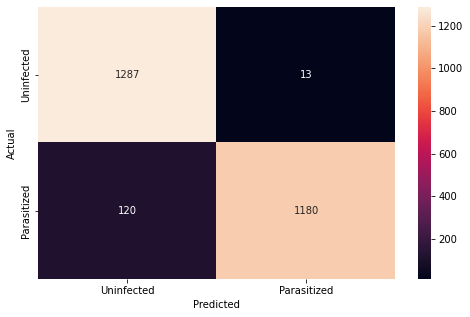

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model2.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [ ]:
backend.clear_session() # Clearing backend for new model

In [ ]:
print(len(train_images))

24958


###<b> Using image data generator

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                  zoom_range = 0.5, rotation_range = 30)

val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)

# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

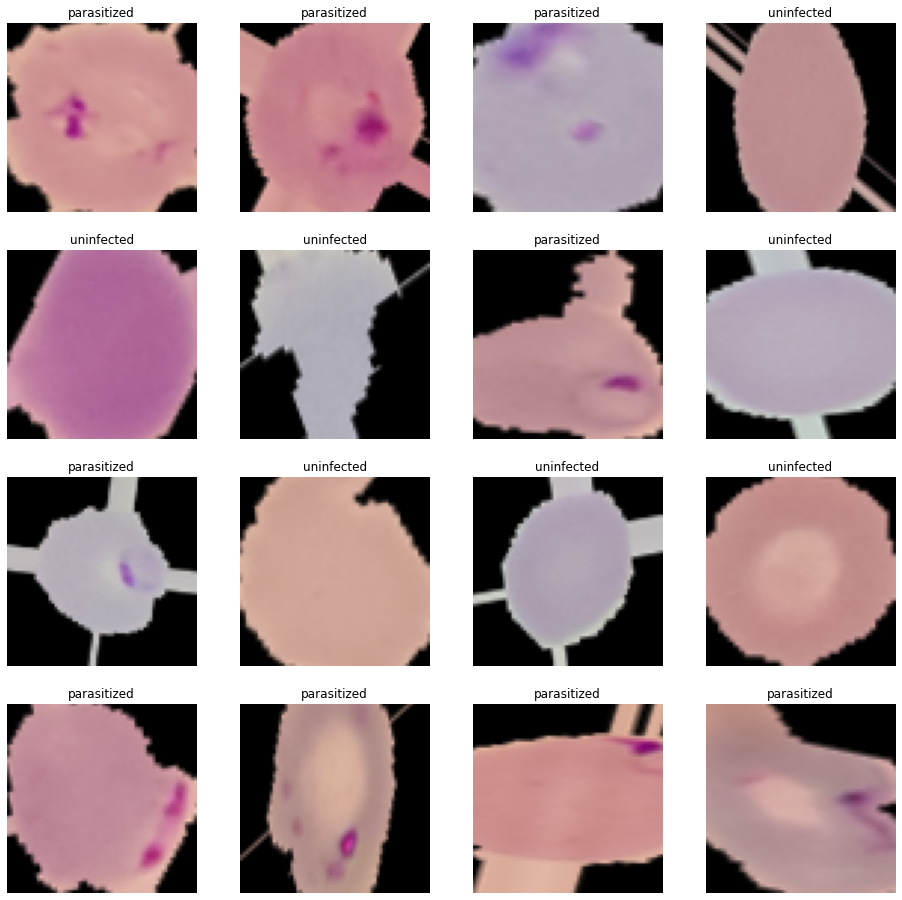

In [ ]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label[1] == 1: 

        ax.set_title('parasitized')

    else:

        ax.set_title('uninfected')

    ax.axis('off')

####<b>Observations and insights: 
for this model we used data augmentation. 
The expectation is that it will generate more variance in data by transforming features and creating more options, how the features manifested in the images. 
-  process is quite conputationally expensive (there was a noticable increase in RAM use) 
- It also didn't work with a standard checkpoint function. (I have to look in this deeper).

###<b>Building the Model

In [ ]:
model3 = Sequential()

# Build the model here
model3.add(Conv2D(32, (3, 3), padding = "same", activation = "leaky_relu", input_shape = (64, 64, 3)))

model3.add(MaxPooling2D(pool_size = 2))

model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "leaky_relu"))

model3.add(MaxPooling2D(pool_size = 2))

#-----------BatchNormalization
model3.add(BatchNormalization())

model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "leaky_relu"))

model3.add(MaxPooling2D(pool_size = 2))

model3.add(Dropout(0.2))

# new layers (we add it before Dense, because Dense layer has a side effect of
#     exponentially increasing the number of features)

#------------------ additional layer 1--------
model3.add(Conv2D(32, (3, 3),  padding = "same"))

model3.add(LeakyReLU(0.1))

model3.add(MaxPooling2D (pool_size = (2)))

#---------------BatchNormalization
model3.add(BatchNormalization())


#------------------ additional layer 2--------
model3.add(Conv2D(filters = 16, kernel_size = 2, padding = "same", activation = "leaky_relu"))

model3.add(MaxPooling2D(pool_size = 2))

model3.add(Dropout(0.2))
#---------------------------------------------

model3.add(Flatten())

model3.add(Dense(512, activation = "leaky_relu"))

model3.add(Dropout(0.4))

model3.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model3.summary()

# Use this as the optimizer
adam = optimizers.Adam(learning_rate = 0.001)

model3.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       1

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [ ]:
history3 = model3.fit(train_generator, 
                                  validation_data = val_generator,
                                  batch_size = 32, callbacks = callbacks,
                                  epochs = 20, verbose = 1)

Epoch 1/20
312/312 [==============================] - 25s 76ms/step - loss: 0.6298 - accuracy: 0.6484 - val_loss: 0.9304 - val_accuracy: 0.5002
Epoch 2/20
312/312 [==============================] - 31s 101ms/step - loss: 0.2314 - accuracy: 0.9158 - val_loss: 0.1440 - val_accuracy: 0.9519
Epoch 3/20
312/312 [==============================] - 25s 81ms/step - loss: 0.1803 - accuracy: 0.9391 - val_loss: 0.0942 - val_accuracy: 0.9724
Epoch 4/20
312/312 [==============================] - 26s 83ms/step - loss: 0.1704 - accuracy: 0.9431 - val_loss: 0.0863 - val_accuracy: 0.9734
Epoch 5/20
312/312 [==============================] - 28s 89ms/step - loss: 0.1678 - accuracy: 0.9447 - val_loss: 0.0851 - val_accuracy: 0.9730
Epoch 6/20
312/312 [==============================] - 24s 77ms/step - loss: 0.1599 - accuracy: 0.9469 - val_loss: 0.0952 - val_accuracy: 0.9728
Epoch 7/20
312/312 [==============================] - 25s 81ms/step - loss: 0.1537 - accuracy: 0.9507 - val_loss: 0.0800 - val_accuracy

###<B>Evaluating the model

<b>Plot the train and validation accuracy

In [ ]:
# Evaluating the model on test data
accuracy3 = model3.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy3[1])

82/82 [==============================] - 0s 4ms/step - loss: 0.0740 - accuracy: 0.9804

 Test_Accuracy:- 0.9803845882415771


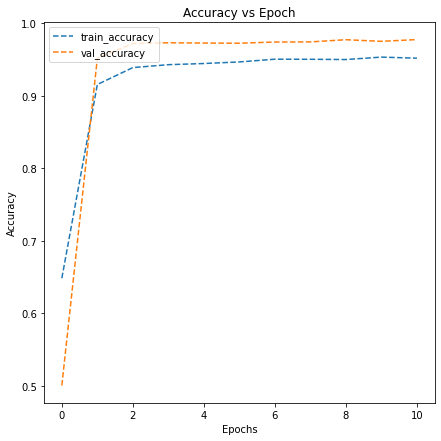

In [ ]:
# Potting the accuracies
plot_accuracy(history3)

<B>Plotting the classification report and confusion matrix

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



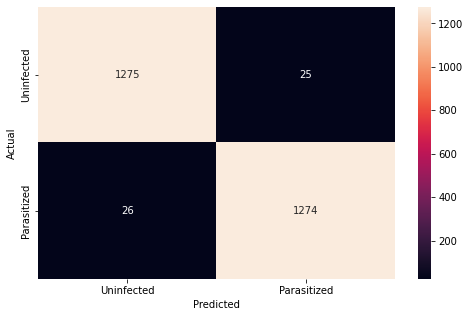

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model3.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**

In [ ]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

# adding a GlobalAveragePooling2D to use in place of Fflatten()
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (64, 64, 3))

vgg.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
transfer_layer = vgg.get_layer('block3_pool')

vgg.trainable = False

# Add classification layers on top of it  

x = GlobalAveragePooling2D()(transfer_layer.output)  # Flatten the output from the 3rd block of the VGG16 model

x = Dense(256, activation = 'relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.3)(x)

# Add a dense layer with 64 neurons
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)

pred = Dense(2, activation = 'softmax')(x)

model4 = Model(vgg.input, pred) # Initializing the model

###<b>Compiling the model

In [ ]:

# Set up the optimizer
adam = optimizers.Adam(learning_rate = 0.001)
# Compiling the model 
model4.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])


<b> using callbacks

In [ ]:
# Adding Callbacks to the model
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
# Fitting the model and running the model for 10 epochs
history4 = model4.fit(train_generator, 
            validation_data = val_generator,
            epochs = 10,
            callbacks = callbacks,
            batch_size = 32,
            validation_split = 0.2,
            verbose = 1
)

Epoch 1/10
312/312 [==============================] - 30s 91ms/step - loss: 0.4238 - accuracy: 0.8039 - val_loss: 0.1748 - val_accuracy: 0.9377
Epoch 2/10
312/312 [==============================] - 26s 85ms/step - loss: 0.2767 - accuracy: 0.8899 - val_loss: 0.1408 - val_accuracy: 0.9473
Epoch 3/10
312/312 [==============================] - 26s 82ms/step - loss: 0.2539 - accuracy: 0.8990 - val_loss: 0.1546 - val_accuracy: 0.9417
Epoch 4/10
312/312 [==============================] - 28s 89ms/step - loss: 0.2406 - accuracy: 0.9065 - val_loss: 0.1352 - val_accuracy: 0.9549
Epoch 5/10
312/312 [==============================] - 27s 87ms/step - loss: 0.2379 - accuracy: 0.9059 - val_loss: 0.1279 - val_accuracy: 0.9539
Epoch 6/10
312/312 [==============================] - 27s 87ms/step - loss: 0.2307 - accuracy: 0.9101 - val_loss: 0.2169 - val_accuracy: 0.9303
Epoch 7/10
312/312 [==============================] - 28s 89ms/step - loss: 0.2168 - accuracy: 0.9159 - val_loss: 0.1191 - val_accuracy:

<b>Plot the train and validation accuracy

In [ ]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

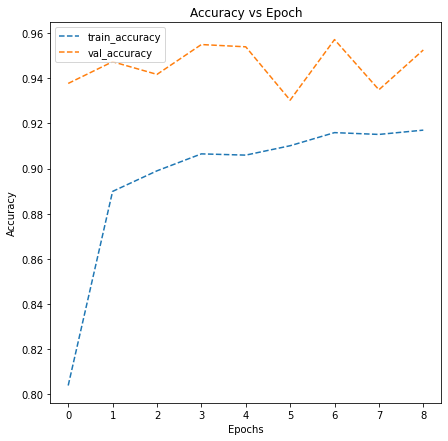

In [ ]:
# plotting the accuracies
plot_accuracy(history4)


###**Observations and insights:**

> the accuracy of the training accuracy is oscillating around an average value of 50%. I suspect it to be due to several reasons: 
- there might be a better model for cells than vgg16, something better suited for Malaria (AlexNet? LeNet5? GoogleNet? ResNet50?)
- the pooling and averaging layers might not be appropriate for the configuration of the vgg16 model.
- the best results are expected with the images withthe same transformation as vgg16, i.e. 224x224x3
- BatchNormalization and learning rates are very important parameters and were reported to affect the model a lot. 

*   What can be observed from the validation and train curves?
> The validation curves oscillate around a mean accuracy value of ~0.5. I think it shows that out learning rate needs better tuning







###<b> Evaluating the model

In [ ]:
# Evaluating the model on test data
accuracy4 = model4.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy4[1])

82/82 [==============================] - 1s 13ms/step - loss: 0.1045 - accuracy: 0.9546

 Test_Accuracy:- 0.9546154141426086


<b>Plotting the classification report and confusion matrix

82/82 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1300
           1       0.96      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



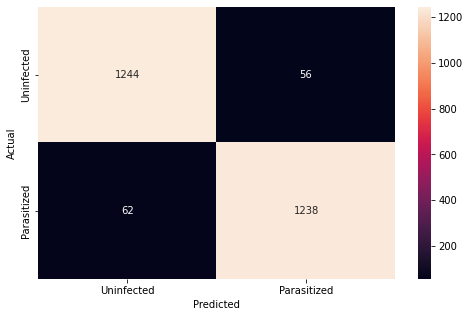

In [ ]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model4.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.

> the model performes slightly worse compared to previous attempts. 
The most worisome issue is that it gives False Negative at least twice more frequently, than False positive.
In the problem set up as a "prescreenening procedure" we are more interested to make as few False Negatives as possible

### **FINAL model transfer learning from ResNet50**

In [ ]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

## i tried resizing the images to 224x224x3 but I run out or RAM on CoLab,
So I will use input shape 64x64x3,
however trainig is more efficient with the images being the same size as the trained model

In [ ]:
from tensorflow.keras.applications import ResNet50

from tensorflow.keras import Model

# from tensorflow.keras.layers import GlobalAveragePooling2D

res50 = ResNet50(include_top = False, weights = 'imagenet', input_shape = (64, 64, 3))

# res50.summary()

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
transfer_layer = res50.get_layer('conv5_block3_add')

res50.trainable = True

# Add classification layers on top of it  
x = Flatten()(transfer_layer.output)  # Flatten the output from the 3rd block of the VGG16 model

# x =GlobalAveragePooling2D()(transfer_layer.output)

x = Dense(256, activation = 'relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dropout(0.2)(x)

# Add a dense layer with 64 neurons
x = BatchNormalization()(x)

pred = Dense(2, activation = 'softmax')(x)

model5 = Model(res50.input, pred) # Initializing the model

In [ ]:
model5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

###<b>Compiling the model

In [ ]:

# Set up the optimizer. we change the learning rate to escape 0.5 accuracy
adam = optimizers.Adam(learning_rate = 0.00001)
# Compiling the model 
model5.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])


<b> using callbacks

In [ ]:
# Adding Callbacks to the model
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
# Fitting the model and running the model for 10 epochs
history5 = model5.fit(train_generator, 
            validation_data = val_generator,
            epochs = 10,
            callbacks = callbacks,
            batch_size = 64,
            validation_split = 0.2,
            verbose = 1
)

Epoch 1/10
312/312 [==============================] - 45s 122ms/step - loss: 0.3541 - accuracy: 0.8613 - val_loss: 1.3980 - val_accuracy: 0.5234
Epoch 2/10
312/312 [==============================] - 37s 119ms/step - loss: 0.2025 - accuracy: 0.9322 - val_loss: 1.0729 - val_accuracy: 0.4920
Epoch 3/10
312/312 [==============================] - 37s 119ms/step - loss: 0.1727 - accuracy: 0.9423 - val_loss: 0.3412 - val_accuracy: 0.8918
Epoch 4/10
312/312 [==============================] - 36s 114ms/step - loss: 0.1607 - accuracy: 0.9459 - val_loss: 0.1014 - val_accuracy: 0.9690
Epoch 5/10
312/312 [==============================] - 36s 114ms/step - loss: 0.1523 - accuracy: 0.9495 - val_loss: 0.0830 - val_accuracy: 0.9732
Epoch 6/10
312/312 [==============================] - 33s 106ms/step - loss: 0.1458 - accuracy: 0.9503 - val_loss: 0.0841 - val_accuracy: 0.9726
Epoch 7/10
312/312 [==============================] - 36s 116ms/step - loss: 0.1340 - accuracy: 0.9548 - val_loss: 0.0724 - val_ac

<b>Plot the train and validation accuracy

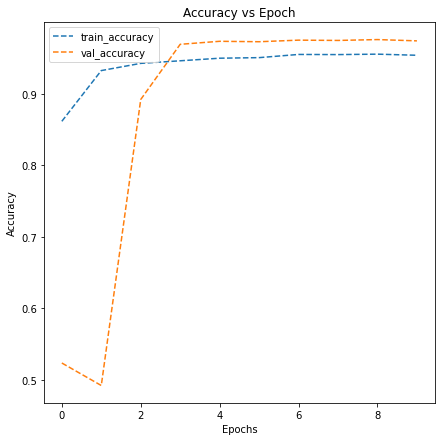

In [ ]:
# plotting the accuracies
plot_accuracy(history5)


###**Observations and insights:**

1.   I like that the validation and traiing accuracy go up fast and stay up without ascillations

2.   the accuracy is comparable to the one reported in the literature 70-98%

*   What can be observed from the validation and train curves?

3.   the fact that the validastion curve is above training accuracy means that there is a room for improvement and we are far from overfitting


4.   Flatten() as a first layer after the ResNet50 layers worked better here than GlobalWverage2D for VGG in the previous model. (I need to look in this more to understand the difference in synthesising effects of these functions)





###<b> Evaluating the model

In [ ]:
# Evaluating the model on test data
accuracy5 = model5.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy5[1])

82/82 [==============================] - 2s 23ms/step - loss: 0.0541 - accuracy: 0.9831

 Test_Accuracy:- 0.9830769300460815


<b>Plotting the classification report and confusion matrix

82/82 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



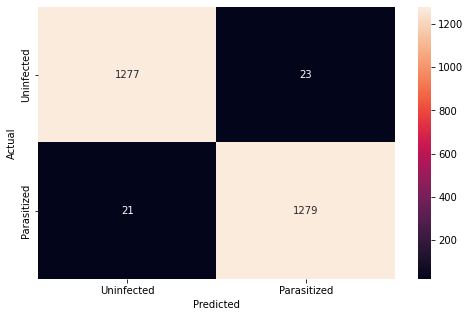

In [ ]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model5.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

####<b> Observations and Conclusions drawn from the final model: 
> ResNet50() gave better results in this specific architecture thatn vgg16. 
Recall improved for both, uninfected (from 97 to 98%) and parazitized (from 93 to 98%) 
This is very important for our case of "prescreening" becasue we don't want to miss an opportunity to treat an infeted person, but don't want to waste valuable resources on following on False Positive reults with extra testing or treat a person unnecessarily.  



**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

#### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?